In [41]:
import pandas as pd 
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import pickle


In [3]:
#read dataset 
df=pd.read_csv("cleaned_dataset.csv")
df.head(5)

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Credit_Amount,Loan_Annuity,Client_Education,Client_Gender,Loan_Contract_Type,...,ID_Days,Client_Family_Members,Cleint_City_Rating,Score_Source_2,Score_Source_3,Phone_Change,Default,balance_ratio,avg_source_score,capablity
0,6750.0,0.0,0.0,1.0,0.0,61190.55,3416.85,4,1,0,...,383.0,2.0,2.0,0.478787,0.478787,63.0,0,9.065267,0.478787,0.506200
1,18000.0,0.0,0.0,1.0,0.0,59527.35,2788.20,1,1,0,...,331.0,2.0,2.0,0.552795,0.329655,277.0,0,3.307075,0.441225,0.154900
2,15750.0,0.0,0.0,1.0,1.0,53870.40,2295.45,4,1,0,...,775.0,2.0,3.0,0.135182,0.631355,1700.0,0,3.420343,0.383268,0.145743
3,33750.0,1.0,0.0,1.0,0.0,133988.40,3547.35,4,0,0,...,4043.0,4.0,1.0,0.301182,0.355639,674.0,0,3.970027,0.328410,0.105107
4,11250.0,0.0,1.0,1.0,1.0,13752.00,653.85,4,0,0,...,3910.0,2.0,2.0,0.697928,0.420611,739.0,0,1.222400,0.559269,0.058120


In [6]:
## Segregation of dependent and independent features
y=df['Default']
X=df.drop('Default',axis=1)

In [7]:
y

0        0
1        0
2        0
3        0
4        0
        ..
81687    1
81688    0
81689    0
81690    0
81691    0
Name: Default, Length: 81692, dtype: int64

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)

In [15]:
preprocessor=StandardScaler()
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [26]:
#ROC dict for TPR and FPR values
roc_dict = {}
#precision recall curve
prc_dict = {}

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [27]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
   
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    clf_report['clf'] = name
    
    return clf_report

In [28]:
## Logistic Regression
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')

modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.917490,0.500000,0.917456,0.708745,0.883028,lr
recall,0.999956,0.000494,0.917456,0.500225,0.917456,lr
f1-score,0.956949,0.000988,0.917456,0.478968,0.878040,lr
support,22485.000000,2023.000000,0.917456,24508.000000,24508.000000,lr


In [29]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')

modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)
modify_prc_dict(clf=gbtree,y_test=y_test,X_test=X_test,name='GBTree',
                dict_modify=prc_dict)
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.917647,0.375000,0.917292,0.646323,0.872854,gbtree
recall,0.999555,0.002966,0.917292,0.501261,0.917292,gbtree
f1-score,0.956851,0.005885,0.917292,0.481368,0.878354,gbtree
support,22485.000000,2023.000000,0.917292,24508.000000,24508.000000,gbtree


In [30]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')

modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)
modify_prc_dict(clf=rf,y_test=y_test,X_test=X_test,name='RandomForest',           
                dict_modify=prc_dict)
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.919889,0.970149,0.920026,0.945019,0.924037,rf
recall,0.999911,0.032130,0.920026,0.516021,0.920026,rf
f1-score,0.958232,0.062201,0.920026,0.510217,0.884270,rf
support,22485.000000,2023.000000,0.920026,24508.000000,24508.000000,rf


In [31]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,subsample=0.9,n_jobs=-1)
xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')

modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)
modify_prc_dict(clf=xgb_clf,y_test=y_test,X_test=X_test,name='XGBoost',
                dict_modify=prc_dict)
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.922265,0.428571,0.915497,0.675418,0.881514,xgb
recall,0.991461,0.071181,0.915497,0.531321,0.915497,xgb
f1-score,0.955612,0.122086,0.915497,0.538849,0.886809,xgb
support,22485.000000,2023.000000,0.915497,24508.000000,24508.000000,xgb


In [32]:
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost'])

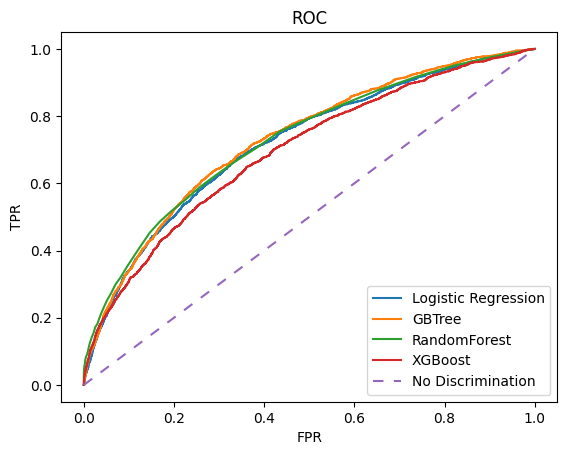

In [34]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('roc_curve_all_models.png'))
plt.legend()
plt.show()

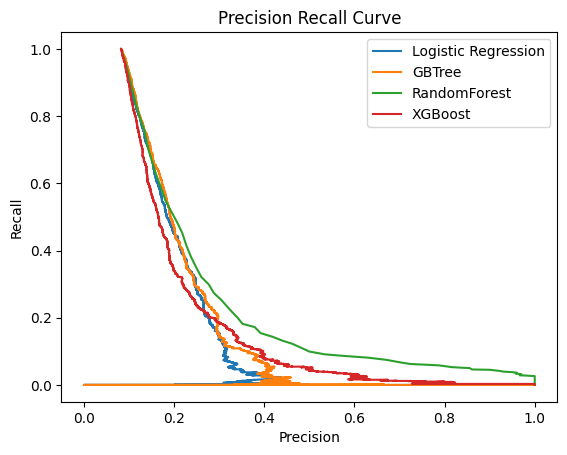

In [35]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('prc_curve_all_models.png'))

plt.legend()

plt.show()

In [37]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
gbtree_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_clf.fit(X_train, y_train)

Estimate: 11.314


GradientBoostingClassifier()

In [44]:
save_model_dir = ('gbtree_default_params.pkl')
print("Saving model as: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(gbtree_clf,handle,protocol=pickle.HIGHEST_PROTOCOL)

Saving model as: gbtree_default_params.pkl


In [46]:
gbtree.feature_importances_(  )

TypeError: 'numpy.ndarray' object is not callable

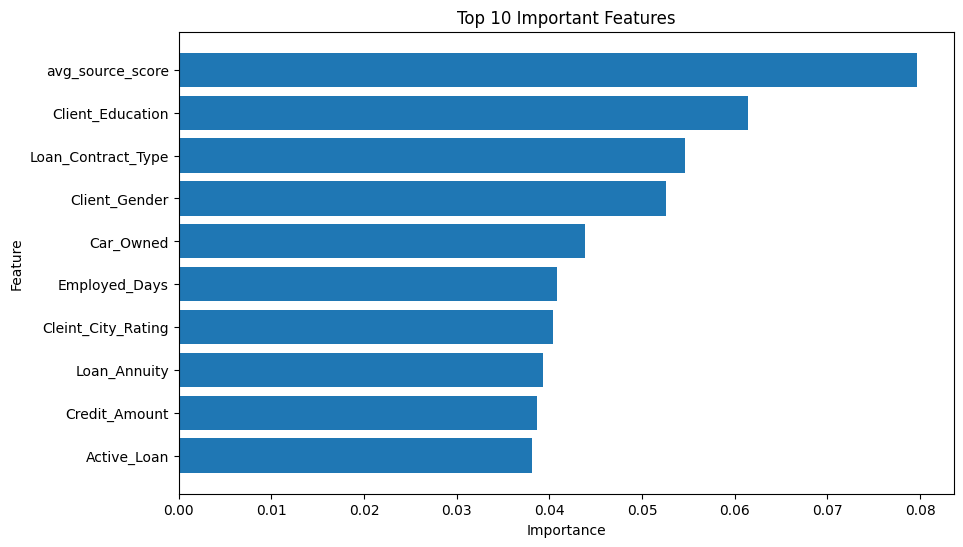

In [47]:
importances = xgb_clf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

k = 10  
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:k], feature_importance_df['Importance'][:k])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Important Features'.format(k))
plt.gca().invert_yaxis()  # invert y-axis to show the most important features at the top
plt.show()

In [58]:
y_pred=gbtree_clf.predict(X_test)
y_prob=gbtree_clf.predict_proba(X_test)

In [60]:
y_prob=y_prob[:, 1] #keeping positive outcome only

In [61]:
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.728
